In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
new_annot_filename = "HD_EPIC_Sounds_annot.csv"
new_annot_df = pd.read_csv(new_annot_filename)
new_annot_df["duration"] = (new_annot_df["stop_sample"] - new_annot_df.start_sample) / 48000
new_annot_df = new_annot_df.sort_values(["participant_id", "video_id", "start_sample"])

In [3]:
def global_iou_tap_to_water(df):
    """
    calculates the iou, considering only overlapping boxes
    for each "water" box, all "tap water" boxes are found and their intersection over union with the water box is calculated
    """
    
    tap = df[df['class'] == 'tap water']
    water = df[df['class'] == 'water']

    total_inter, total_union = 0, 0

    results = []

    # for each video, get iou for all annotations. save together with video, lengths and part. id
    for vid in set(tap['video_id']) | set(water['video_id']):
        tap_vid = tap[tap['video_id'] == vid]
        water_vid = water[water['video_id'] == vid]
        # for each water event, aggregate all overlapping "tap water" events, and get the iou.
        for _, row_water in water_vid.iterrows():
            inter_row = 0
            union_row = row_water.stop_sample - row_water.start_sample
            for _, row_tap in tap_vid.iterrows():
                inter_start = max(row_tap['start_sample'], row_water['start_sample'])
                inter_end = min(row_tap['stop_sample'], row_water['stop_sample'])
                inter = max(0, inter_end - inter_start)
                inter_row += inter
                if inter == 0:  # overlap is 0 cause one starts after the other ends
                    continue
                union_row += max(row_water.start_sample - row_tap.start_sample, 0)
                union_row += max(row_tap.stop_sample - row_water.stop_sample, 0)
            total_inter += inter_row
            total_union += union_row
            results.append([vid, vid[:3], inter_row, union_row, inter_row / union_row, row_water.start_timestamp])

    return pd.DataFrame(results, columns=["video_id", "participant_id", "inter", "union", "iou", "start_ts"])

In [4]:
from itertools import chain

def merge_intervals(intervals):
    """Merge a list of [start, end] intervals"""
    if not intervals:
        return []
    intervals = sorted(intervals)
    merged = [intervals[0]]
    for start, end in intervals[1:]:
        last_start, last_end = merged[-1]
        if start <= last_end:
            merged[-1][1] = max(last_end, end)
        else:
            merged.append([start, end])
    return merged

def interval_length(intervals):
    """Sum of lengths of intervals"""
    return sum(end - start for start, end in intervals)

def intersect_intervals(a, b):
    """Compute intersection between two interval lists"""
    intersections = []
    for sa, ea in a:
        for sb, eb in b:
            start = max(sa, sb)
            end = min(ea, eb)
            if start < end:
                intersections.append([start, end])
    return merge_intervals(intersections)

def iou_per_video(df):
    results = []

    for vid in df['video_id'].unique():
        df_vid = df[df['video_id'] == vid]
        participant_id = vid[:3]  # or use a column if available

        water_intervals = merge_intervals(
            df_vid[df_vid['class'] == 'water'][['start_sample', 'stop_sample']].values.tolist()
        )
        tap_intervals = merge_intervals(
            df_vid[df_vid['class'] == 'tap water'][['start_sample', 'stop_sample']].values.tolist()
        )

        inter = interval_length(intersect_intervals(water_intervals, tap_intervals))
        union = interval_length(merge_intervals(water_intervals + tap_intervals))
        iou = inter / union if union > 0 else 0

        results.append({
            "video_id": vid,
            "participant_id": participant_id,
            "inter": inter,
            "union": union,
            "iou": iou
        })

    return pd.DataFrame(results)

In [5]:
## calculate intersection over union of water and tap water labels:
both_df = new_annot_df[(new_annot_df["class"] == "tap water") | (new_annot_df["class"] == "water")]
both_df_3 = both_df[both_df.duration >= 3]
iou_3 = iou_per_video(both_df_3)

In [6]:
### make sure that no 2 tap annotations overlap:
for i, row in both_df[both_df["class"] == "tap water"].iterrows():
    for j, row2 in both_df[both_df["class"] == "tap water"].iterrows():
        if j == i:
            continue
        if row.video_id != row2.video_id:
            continue
        if max(0, min(row['stop_sample'], row2['stop_sample']) - max(row['start_sample'], row2['start_sample'])) != 0:
            print(row.video_id, row.start_timestamp, row.stop_timestamp, row2.start_timestamp, row2.stop_timestamp)
print("done checking, no illegal overlap!")

done checking, no illegal overlap!


In [7]:
iou_3

,video_id,participant_id,inter,union,iou
0,P01-20240202-110250,P01,1841568,4644576,0.396499
1,P01-20240202-161354,P01,1207585,2799024,0.431431
2,P01-20240202-161948,P01,0,341376,0.000000
3,P01-20240202-171220,P01,1544016,2852063,0.541368
4,P01-20240202-175627,P01,1524097,5472577,0.278497
...,...,...,...,...,...
122,P09-20240623-153253,P09,2029440,2688240,0.754933
123,P09-20240623-153748,P09,1373184,1506143,0.911722
124,P09-20240623-154547,P09,0,339312,0.000000
125,P09-20240624-160737,P09,5057327,6695328,0.755352


## IOU over the water and tap water labels:

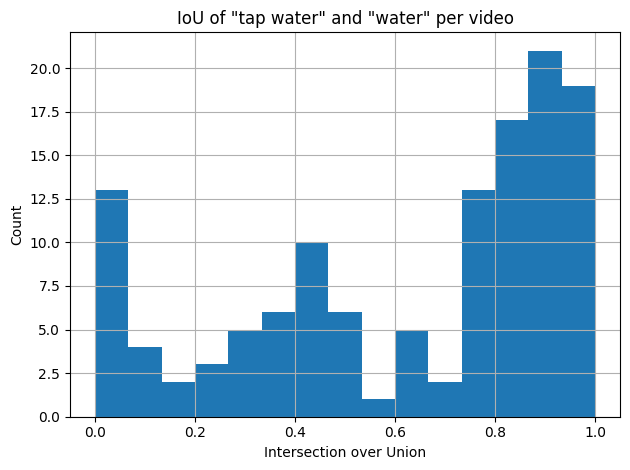

In [8]:
iou_3.iou.hist(bins=15)
plt.title("IoU of \"tap water\" and \"water\" per video")
plt.xlabel("Intersection over Union")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/iou_hist.pdf")

## IoU over the entire dataset:

In [9]:
iou_total = iou_3.inter.sum() / iou_3.union.sum()
print(f"IoU: {iou_total:.4f}")

IoU: 0.6162


In [11]:
iou_part = iou_3.groupby("participant_id").sum(numeric_only=True)
iou_part["iou"] = iou_part.inter / iou_part.union
iou_part = iou_part.drop(["inter", "union"], axis=1)
iou_part.index.name= "participant"
iou_part = iou_part.rename({"participant_id": "participant", "iou": "IoU"}, axis=1).T


latex_output = iou_part.style.format(precision=3).to_latex(
                                         hrules=True)
# Optionally save to file
with open('tables/iou_per_part.tex', 'w') as f:
    f.write(latex_output)
iou_part

participant,P01,P02,P03,P04,P05,P06,P07,P08,P09
IoU,0.363606,0.429076,0.613843,0.841853,0.651225,0.87137,0.915508,0.541769,0.61752


## Comparison of label durations, with and without 3s rule:

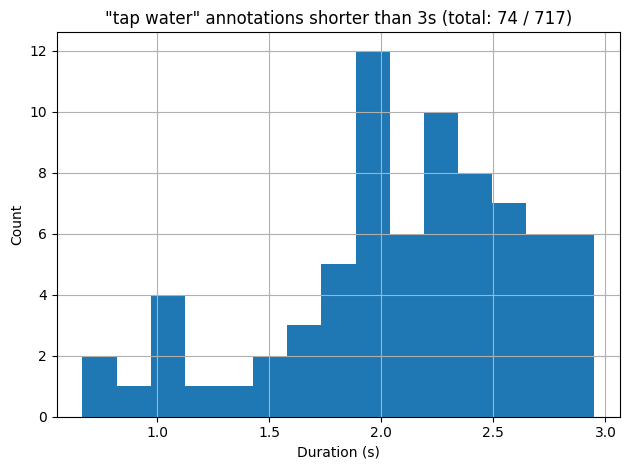

In [12]:
tap_df = both_df[both_df.class_id==44]
tap_df[tap_df.duration < 3].duration.hist(bins=15)
plt.title("\"tap water\" annotations shorter than 3s (total: 74 / 717)")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/short_tap_water_hist.pdf")

<Axes: >

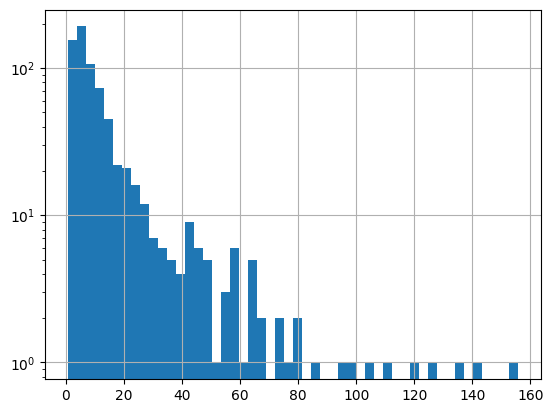

In [13]:
both_df[both_df.class_id==44].duration.hist(bins=50, log=True)

Text(0.5, 0, 'Duration')

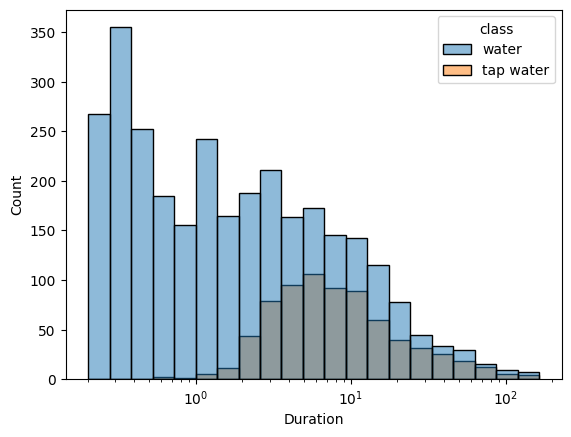

In [14]:
sns.histplot(data=both_df, x="duration", hue="class", log_scale=(True, False))
plt.xlabel("Duration")

In [15]:
both_df.groupby("class").duration.sum()

class
tap water     9594.574354
water        16981.142604
Name: duration, dtype: float64

In [16]:
dur_df = both_df.groupby(["participant_id", "class"]).duration.sum()
dur_df = pd.DataFrame(dur_df).reset_index()
pivoted_df = dur_df.pivot(index='participant_id', columns='class', values='duration').reset_index()

# Reset index if you want participant_id back as a normal column
pivoted_df = pivoted_df.reset_index(drop=True)
pivoted_df.columns = [
    ("", 'participant_id'),  # empty top level for participant_id
    ('class', 'tap water'),
    ('class', 'water')
]
pivoted_df.columns = pd.MultiIndex.from_tuples(pivoted_df.columns)

latex_output = pivoted_df.style.hide(axis="index").format(precision=1).to_latex(multicol_align='c',
                                         hrules=True)
# Optionally save to file
with open('tables/durations.tex', 'w') as f:
    f.write(latex_output)
pivoted_df

class             
  participant_id    tap water        water
0            P01   895.380021  2737.151250
1            P02   765.342896  2189.149979
2            P03  1821.168229  3261.017125
3            P04  1474.320042  1872.029208
4            P05   297.809979   541.459083
5            P06  1432.175979  1588.871958
6            P07   789.912021   944.498000
7            P08   990.465125  1838.341104
8            P09  1128.000063  2008.624896

In [17]:
both_df_3.groupby("class").duration.sum()

class
tap water     9439.194250
water        15182.239479
Name: duration, dtype: float64

In [18]:
dur_3_df = both_df_3.groupby(["participant_id", "class"]).duration.sum()
dur_3_df = pd.DataFrame(dur_3_df).reset_index()
pivoted_df2 = dur_3_df.pivot(index='participant_id', columns='class', values='duration').reset_index()

# Reset index if you want participant_id back as a normal column
pivoted_df2 = pivoted_df2.reset_index(drop=True)
pivoted_df2.columns = [
    ("", 'participant_id'),  # empty top level for participant_id
    ('class', 'tap water'),
    ('class', 'water')
]
pivoted_df2.columns = pd.MultiIndex.from_tuples(pivoted_df.columns)

latex_output = pivoted_df2.style.hide(axis="index").format(precision=1).to_latex(multicol_align='c',
                                         hrules=True)
# Optionally save to file
with open('tables/durations.tex', 'w') as f:
    f.write(latex_output)
pivoted_df2

class             
  participant_id    tap water        water
0            P01   832.477000  2491.807000
1            P02   752.254917  1758.263042
2            P03  1787.519146  3025.744125
3            P04  1457.357021  1732.960104
4            P05   294.932979   427.843021
5            P06  1429.383979  1458.602021
6            P07   789.912021   844.355042
7            P08   984.140125  1754.683167
8            P09  1111.217063  1687.981958

In [19]:
key = ('', 'participant_id')

In [20]:
joined_df = joined_df = (
    pivoted_df
    .set_index(('', 'participant_id'))
    .join(
        pivoted_df2.set_index(('', 'participant_id')),
        rsuffix=' >= 3s'
    )
    .reset_index()
)

In [21]:
joined_df[("class", "tap water")]

0     895.380021
1     765.342896
2    1821.168229
3    1474.320042
4     297.809979
5    1432.175979
6     789.912021
7     990.465125
8    1128.000063
Name: (class, tap water), dtype: float64

In [22]:
joined_df.loc[len(joined_df)] = joined_df.sum()

In [23]:
import warnings

In [24]:
warnings.filterwarnings('ignore')
joined_df[("","participant_id")].iloc[-1] = "Agg."
joined_df[("ratio","water")] = joined_df[("class >= 3s", "water")] / joined_df[("class", "water")]
joined_df[("ratio","tap water")] = joined_df[("class >= 3s", "tap water")] / joined_df[("class", "tap water")]
joined_df[("ratio tap water/water", "")] = joined_df[("class", "tap water")] / joined_df[("class", "water")]
joined_df[("ratio >= 3s tap water/water", "")] = joined_df[("class >= 3s", "tap water")] / joined_df[("class >= 3s", "water")]

latex_output = joined_df.style.hide(axis="index").format(precision=2).to_latex(multicol_align='c',
                                         hrules=True)
# Optionally save to file
with open('tables/durations.tex', 'w') as f:
    f.write(latex_output)

joined_df

class                class >= 3s                \
  participant_id    tap water         water    tap water         water   
0            P01   895.380021   2737.151250   832.477000   2491.807000   
1            P02   765.342896   2189.149979   752.254917   1758.263042   
2            P03  1821.168229   3261.017125  1787.519146   3025.744125   
3            P04  1474.320042   1872.029208  1457.357021   1732.960104   
4            P05   297.809979    541.459083   294.932979    427.843021   
5            P06  1432.175979   1588.871958  1429.383979   1458.602021   
6            P07   789.912021    944.498000   789.912021    844.355042   
7            P08   990.465125   1838.341104   984.140125   1754.683167   
8            P09  1128.000063   2008.624896  1111.217063   1687.981958   
9           Agg.  9594.574354  16981.142604  9439.194250  15182.239479   

      ratio           ratio tap water/water ratio >= 3s tap water/water  
      water tap water                                                    
0  0.910365  0.929747              0.327121                    0.334086  
1  0.803172  0.982899              0.349607                    0.427840  
2  0.927853  0.981523              0.558466                    0.590770  
3  0.925712  0.988494              0.787552                    0.840964  
4  0.790167  0.990339              0.550014                    0.689349  
5  0.918011  0.998051              0.901379                    0.979968  
6  0.893972  1.000000              0.836330                    0.935521  
7  0.954493  0.993614              0.538782                    0.560865  
8  0.840367  0.985121              0.561578                    0.658311  
9  0.894065  0.983805              0.565013                    0.621726

In [25]:
def containment_ratio_tap_in_water(df):
    results = []

    for vid in df['video_id'].unique():
        df_vid = df[df['video_id'] == vid]
        participant_id = vid[:3]  # adjust if needed

        water_intervals = merge_intervals(
            df_vid[df_vid['class'] == 'water'][['start_sample', 'stop_sample']].values.tolist()
        )
        tap_intervals = merge_intervals(
            df_vid[df_vid['class'] == 'tap water'][['start_sample', 'stop_sample']].values.tolist()
        )

        overlap = interval_length(intersect_intervals(water_intervals, tap_intervals))
        total_tap = interval_length(tap_intervals)

        containment = overlap / total_tap if total_tap > 0 else 0

        results.append({
            "video_id": vid,
            "participant_id": participant_id,
            "overlap": overlap,
            "tap_total": total_tap,
            "containment": containment
        })
    return pd.DataFrame(results)

In [26]:
cont = containment_ratio_tap_in_water(both_df)

In [27]:
cont

,video_id,participant_id,overlap,tap_total,containment
0,P01-20240202-110250,P01,1841857,1847905,0.996727
1,P01-20240202-161354,P01,1209264,1246080,0.970455
2,P01-20240202-161948,P01,0,0,0.000000
3,P01-20240202-171220,P01,1544016,1544016,1.000000
4,P01-20240202-175627,P01,1630658,1630658,1.000000
...,...,...,...,...,...
134,P09-20240623-153253,P09,2029440,2095872,0.968303
135,P09-20240623-153748,P09,1373184,1373184,1.000000
136,P09-20240623-154547,P09,0,0,0.000000
137,P09-20240624-160737,P09,5292143,5292143,1.000000


In [28]:
cont_part = cont.groupby("participant_id").sum(numeric_only=True)
cont_part = cont_part.overlap / cont_part.tap_total
pd.DataFrame(cont_part).T.style.format(precision=3).to_latex()

'\\begin{tabular}{lrrrrrrrrr}\nparticipant_id & P01 & P02 & P03 & P04 & P05 & P06 & P07 & P08 & P09 \\\\\n0 & 0.999 & 0.995 & 0.991 & 0.983 & 0.976 & 0.927 & 0.993 & 0.984 & 0.968 \\\\\n\\end{tabular}\n'

In [29]:
pd.DataFrame(cont_part).T

participant_id,P01,P02,P03,P04,P05,P06,P07,P08,P09
0,0.999003,0.995044,0.990772,0.983414,0.976166,0.927373,0.992628,0.983841,0.967991


In [30]:
cont.overlap.sum() / cont.tap_total.sum()

0.9775923249713208